# Data Wrangling for [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

https://medium.com/analytics-vidhya/machine-learning-to-predict-taxi-fare-part-one-exploratory-analysis-6b7e6b1fbc78

---

## Hypothesis Generation

To solve any analytics problems, list down a set of hypothesis. In this case, they are factors that will affect the cost of a taxi trip:

- Trip distance affects the price;
- Traffic hours might affect the price;
- Number of drivers available might affect the price;
- Weekdays VS weekends, affects the price;
- Late night hours might affect the price;
- Certain pickup or drop-off locations might affect the price;

## 1. Load Datasets

In [1]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import subprocess
import seaborn as sns
sns.set()

# LARGE CSV LOAD and FAST: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows
# def file_len(fname):
#     p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     result, err = p.communicate()
#     if p.returncode != 0:
#         raise IOError(err)
#     return int(result.strip().split()[0])+1

# train_rows = file_len('data/train.csv')  # 55423857
train_rows = 55423857
print (f'>>> Exact number of rows: {train_rows}')

>>> Exact number of rows: 55423857


In [2]:
test_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/sample_submission.csv')

try:
    train_df = pd.read_csv('data/train.csv', nrows=round(train_rows*0.10)) # loads only 10% of the data
except FileNotFoundError:
    print('>>> You must download train.csv from: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/download/train.csv')

In [3]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542386 entries, 0 to 5542385
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.1 GB


In [4]:
print('\n>>> train_df shape', train_df.shape)
display(train_df.head())


>>> train_df shape (5542386, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
print('\n>>> test_df shape', test_df.shape)
display(test_df.head())


>>> test_df shape (9914, 7)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
print('\n>>> submission_df shape', submission_df.shape)
display(submission_df.head())


>>> submission_df shape (9914, 2)


,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


## 2. Data Cleaning

In [7]:
# Check missing data
print(train_df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64


In [8]:
# Checks numeric columns for negative numbers
def check_numeric(df):     
    neg_count_df = pd.DataFrame(columns=['Negative values count'])
    
    #print('>>> Number of negative values found in numeric columns:')
    num_col_list = list(df.select_dtypes(include=['int64', 'float64']).columns)    
    
    total_neg = 0
    for col_name in num_col_list:
        neg_count = df[df[col_name] < 0].shape[0]  # extract number of rows        
        #print('\t*' + col_name+ '* = ' + str(neg_count))
        neg_count_df.loc[col_name] = neg_count
        total_neg += neg_count
    
    return neg_count_df, total_neg


# count how many negative values are there
neg_count_df, total_neg_count = check_numeric(train_df)
display(neg_count_df)

,Negative values count
fare_amount,236
pickup_longitude,5433997
pickup_latitude,2896
dropoff_longitude,5434109
dropoff_latitude,2913
passenger_count,0


In [9]:
# Remove NaNs and Negative & Free fares (keeping only the ones that cost more than 0)
train_df.dropna(inplace=True, axis=0)
train_df = train_df[train_df['fare_amount'] > 0]

# Cast pickup_datetime to type Datetime
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [18]:
print(train_df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5541968 entries, 0 to 5542385
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 785.8 MB
None


## 3. Preliminary EDA

### Distribution of fare amount

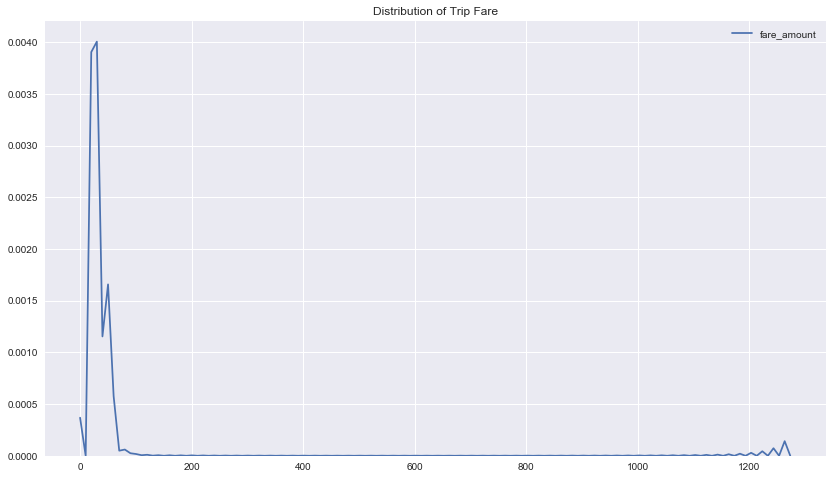

In [11]:
plt.figure(figsize=(14,8))
sns.kdeplot(train_df['fare_amount']).set_title("Distribution of Trip Fare")
plt.show()

Since we saw above that fare amount is highly skewed,let us take log transformation of the fare amount and plot the distribution:

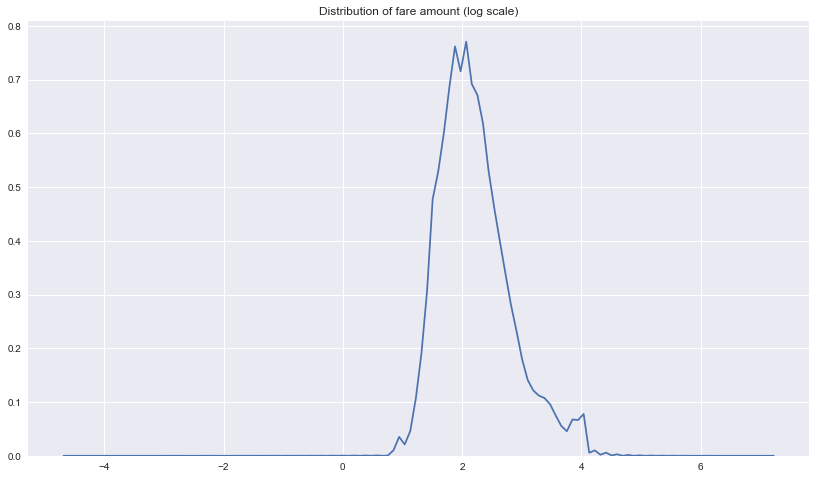

In [12]:
plt.figure(figsize=(14,8))
sns.kdeplot(np.log(train_df['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")
plt.show()

### Distribution of Geographical Features

In [13]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

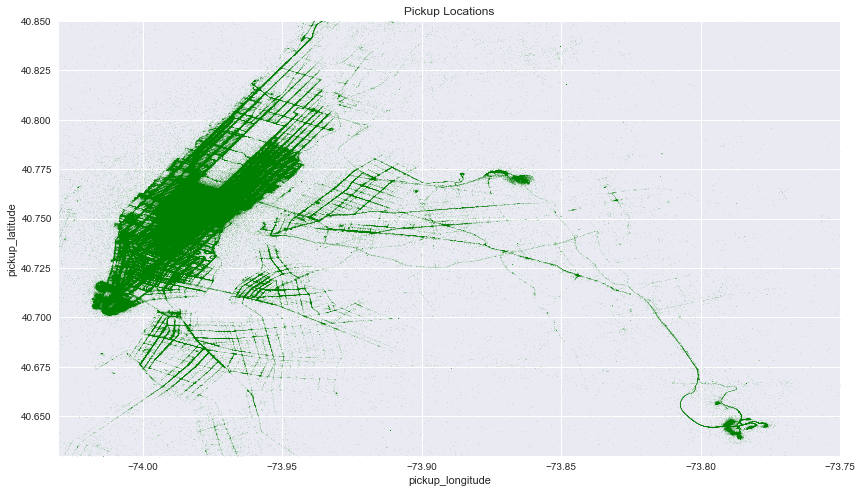

In [14]:
plt.figure(figsize=(14,8))
train_df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', color='green', s=.02, alpha=.6, ax=plt.gca())
plt.title("Pickup Locations")
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

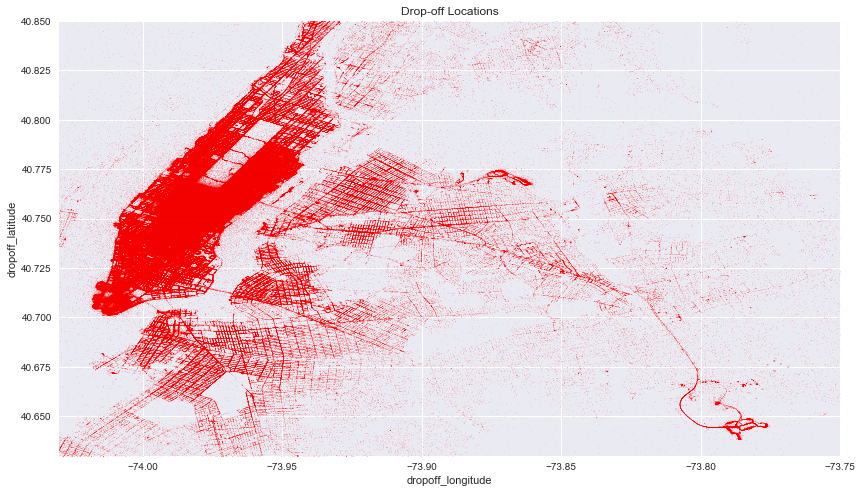

In [15]:
plt.figure(figsize=(14,8))
train_df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', color='red', s=.02, alpha=.6, ax=plt.gca())
plt.title("Drop-off Locations")
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [16]:
import folium

pickup_unique_coords_df = train_df.drop_duplicates(subset=['pickup_longitude', 'pickup_latitude'], keep='first', inplace=False)
dropoff_unique_coords_df = train_df.drop_duplicates(subset=['dropoff_longitude', 'dropoff_latitude'], keep='first', inplace=False)

print('>>> Ploting map with', pickup_unique_coords_df.shape[0], 'pickup locations.')
print('>>> Ploting map with', dropoff_unique_coords_df.shape[0], 'dropoff locations.')

ny_map = folium.Map(location=[40.77, -73.8], zoom_start=11, tiles="Stamen Terrain")

### Draw circles on every pickup location: SUPER SLOW, DONT DO IT
# for _, row in pickup_unique_coords_df.iterrows():
#     folium.CircleMarker(location=[row['pickup_latitude'], row['pickup_longitude']], radius=4, color='#00FF00', weight=0.6, opacity=1.0, fill=True, fill_color='#ff5733', fill_opacity=1.0).add_to(ny_map)
### Draw circles on every drop-off location: SUPER SLOW, DONT DO IT
# for _, row in dropoff_unique_coords_df.iterrows():
#     folium.CircleMarker(location=[row['dropoff_latitude'], row['dropoff_longitude']], radius=4, color='#FF0000', weight=0.6, opacity=1.0, fill=True, fill_color='#ff5733', fill_opacity=1.0).add_to(ny_map)    
    
### Draw pickup heatmap: SUPER SLOW, DONT DO IT
# from folium.plugins import HeatMap
# heat_data = [[row['pickup_latitude'],row['pickup_longitude']] for index, row in pickup_unique_coords_df.iterrows()]
# HeatMap(heat_data).add_to(ny_map)   
        
display(ny_map)

>>> Ploting map with 5370081 pickup locations.
>>> Ploting map with 5396234 dropoff locations.
